/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.182 s.


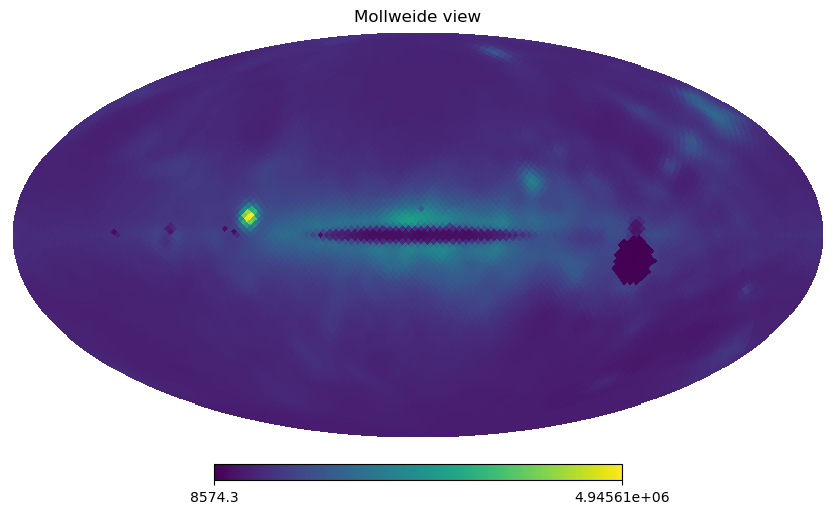

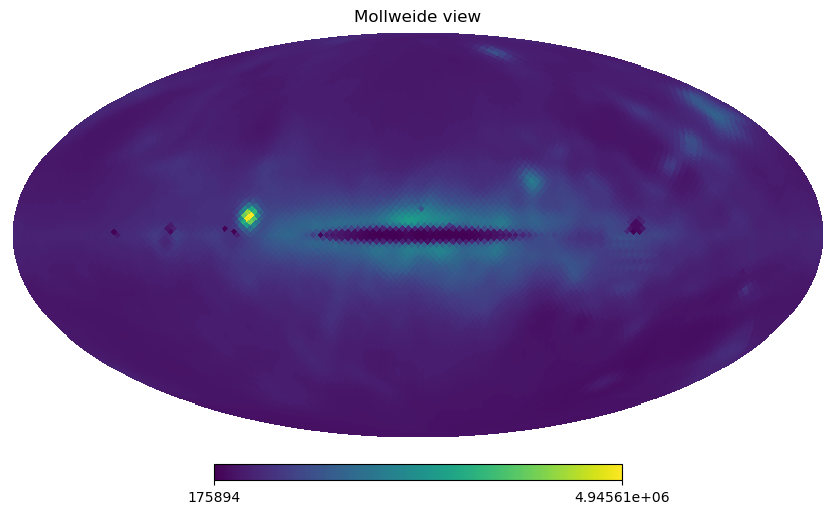

In [1]:
# boiler plate for most pylinex 21-cm stuff

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor
import spiceypy as spice
from datetime import datetime
import enlighten

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

Prepared Haslam map in 0.0947 s.


rms mean is 0.06338719259542634
rms std is 0.011957408210242944


100%|██████████| 221/221 [00:03<00:00, 60.36it/s]


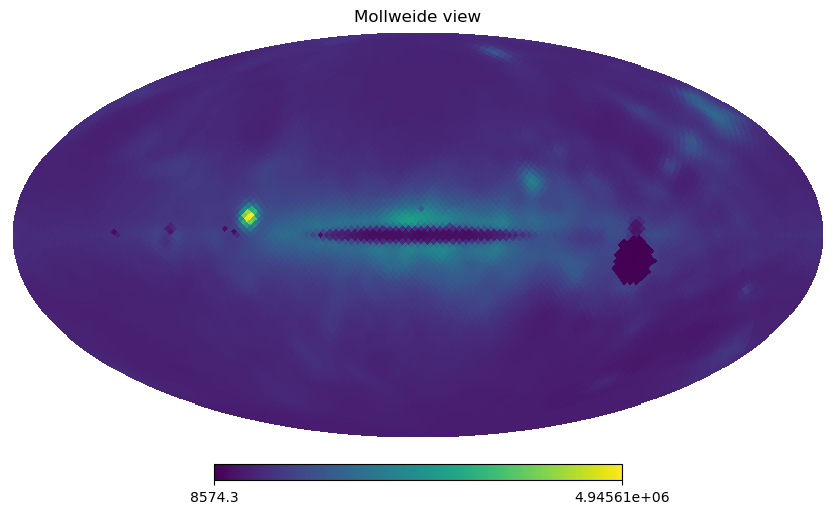

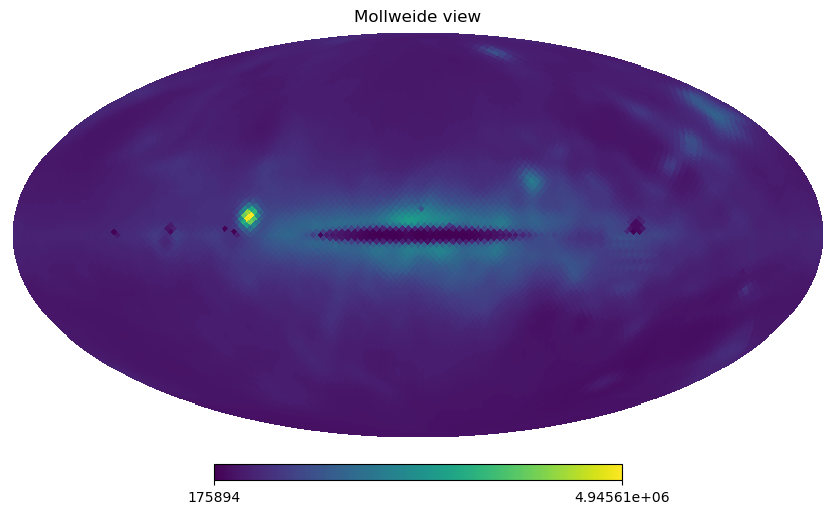

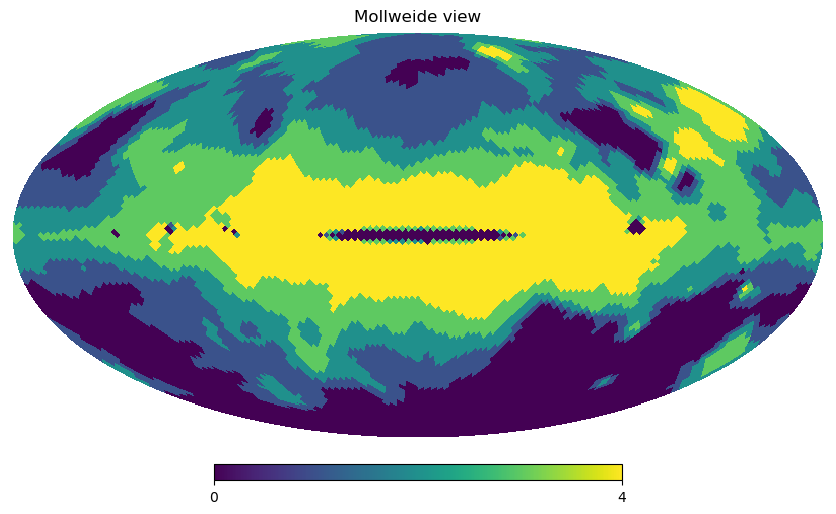

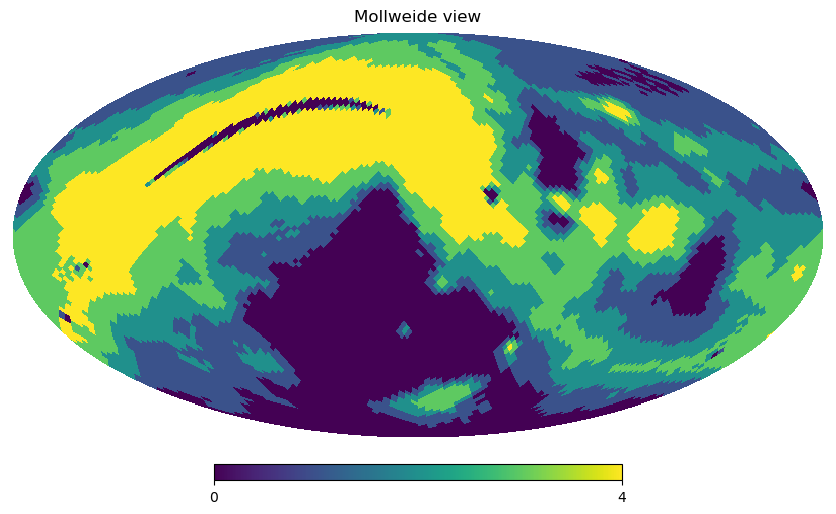

In [2]:
# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.19)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 5000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=True,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=True,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)



In [3]:

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
labmdaCDM_training_set = f["signal_training_set"][0:5000]
labmdaCDM_training_set_params = f["signal_training_set_parameters"][0:5000]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"][0:5000]
DMAN_training_set_params = f["signal_training_set_parameters"][0:5000]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"][0:5000]
DMD_training_set_params = f["signal_training_set_parameters"][0:5000]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"][0:5000]
EDE_training_set_params = f["signal_training_set_parameters"][0:5000]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"][0:5000]
ERB_training_set_params = f["signal_training_set_parameters"][0:5000]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"][0:5000]
MCDM_training_set_params = f["signal_training_set_parameters"][0:5000]

# Let's make some different LSTs
LST = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/LST_10_Base_Foregrounds","r")
foreground_array_minCMB_2 = LST["LST_2"]
foreground_array_minCMB_3 = LST["LST_3"]
foreground_array_minCMB_4 = LST["LST_4"]
foreground_array_minCMB_5 = LST["LST_5"]
foreground_array_minCMB_6 = LST["LST_6"]
foreground_array_minCMB_7 = LST["LST_7"]
foreground_array_minCMB_8 = LST["LST_8"]
foreground_array_minCMB_9 = LST["LST_9"]
foreground_array_minCMB_10 = LST["LST_10"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_2","r")
varied_regolith_training_set_raw_2 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_2 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_3","r")
varied_regolith_training_set_raw_3 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_3 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_4","r")
varied_regolith_training_set_raw_4 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_4 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_5","r")
varied_regolith_training_set_raw_5 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_5 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_6","r")
varied_regolith_training_set_raw_6 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_6 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_7","r")
varied_regolith_training_set_raw_7 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_7 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_8","r")
varied_regolith_training_set_raw_8 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_8 = f["Parameters_of_Beams"]

f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set_9","r")
varied_regolith_training_set_raw_9 = f["Foreground_Training_Set"]
varied_regolith_training_set_raw_parameters_9 = f["Parameters_of_Beams"]

In [4]:
### uncomment to create the exotic training sets ###
# N=10000
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","w")
# dset01 = f.create_dataset("signal_training_set",data=signal_training_set_lambdaCDM[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=signal_training_set_lambdaCDM[1])
# f.close()

# parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
# DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","w")
# dset01 = f.create_dataset("signal_training_set",data=DMAN_training_set)
# dset02 = f.create_dataset("signal_training_set_parameters",data=DMAN_training_set[1])
# f.close()

# parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
# DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","w")
# dset01 = f.create_dataset("signal_training_set",data=DMD_training_set[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=DMD_training_set[1])
# f.close()

# parameters_MCDM = [[0.1,0.5,2,5,10]]
# MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","w")
# dset01 = f.create_dataset("signal_training_set",data=MCDM_training_set[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=MCDM_training_set[1])
# f.close()

# parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
# EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","w")
# dset01 = f.create_dataset("signal_training_set",data=EDE_training_set[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=EDE_training_set[1])
# f.close()

# parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
# ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)
# f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","w")
# dset01 = f.create_dataset("signal_training_set",data=ERB_training_set[0])
# dset02 = f.create_dataset("signal_training_set_parameters",data=ERB_training_set[1])
# f.close()

In [5]:
## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB[0]
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = DMAN_training_set[10]

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_1 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_2[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_2 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_2[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_3[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_3 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_3[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_4[0]




## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_4 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_4[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_5[0]
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_5 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_5[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_6[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_6 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_7[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_7 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_8[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_8 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

## Creates a foreground for the simulation:
sky_map = foreground_array_minCMB_9[0]


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam_9 = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

# Determine RMS
rms_array = np.array([])
frequency_bins = len(frequencies)
for n in range(10000):
    curve = np.ones(frequency_bins)
    for i in range(len(curve)):
        curve[i] = curve[i]*np.random.normal(scale=sigT(simulation_test_beam_1[0][i],dnu,dt)) 
    rms = np.sqrt(np.mean(curve**2))
    rms_array = np.append(rms_array,rms)
rms_std = rms_array.std()
rms_mean = np.mean(rms_array)
print(f"rms mean is {rms_mean}")
print(f"rms std is {rms_std}")

100%|██████████| 2/2 [00:00<00:00, 2188.52it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06338576645738137
rms std is 0.012136121513101094


100%|██████████| 2/2 [00:00<00:00, 19239.93it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59280901e+01 -2.65245437e+00 -1.36709202e-02  1.66185863e+01
 -2.69051177e+00 -1.47624161e-02  1.90420074e+01 -2.68048752e+00
 -1.32106454e-02  2.43977173e+01 -2.66231916e+00 -1.14122613e-02
  5.19342605e+01 -2.65390532e+00 -2.46599299e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.051573123183538565
rms std is 0.009689854515875666


100%|██████████| 2/2 [00:00<00:00, 3336.76it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58763248e+01 -2.65454951e+00 -1.39802429e-02  1.66197586e+01
 -2.69039055e+00 -1.47288410e-02  1.89772651e+01 -2.68251891e+00
 -1.34935464e-02  2.43580532e+01 -2.66291547e+00 -1.13890083e-02
  5.20797564e+01 -2.65246347e+00 -2.45300151e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.05558594451166959
rms std is 0.010576539138890508


100%|██████████| 2/2 [00:00<00:00, 6864.65it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59246051e+01 -2.65270889e+00 -1.37350431e-02  1.66162488e+01
 -2.69045120e+00 -1.47234912e-02  1.89737963e+01 -2.68278334e+00
 -1.35766306e-02  2.44410790e+01 -2.66118795e+00 -1.12346545e-02
  5.19606311e+01 -2.65360484e+00 -2.46124036e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06336641556091745
rms std is 0.012278130091301055


100%|██████████| 2/2 [00:00<00:00, 4485.89it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59214249e+01 -2.65275872e+00 -1.37228529e-02  1.66024553e+01
 -2.69086971e+00 -1.47693988e-02  1.89958066e+01 -2.68230500e+00
 -1.35522636e-02  2.42946029e+01 -2.66448855e+00 -1.16593663e-02
  5.21193413e+01 -2.65182889e+00 -2.43758612e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.07184219845982177
rms std is 0.01376361525810678


100%|██████████| 2/2 [00:00<00:00, 4868.61it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58787984e+01 -2.65442819e+00 -1.39627576e-02  1.65998816e+01
 -2.69102887e+00 -1.48026221e-02  1.90649135e+01 -2.68011276e+00
 -1.32257805e-02  2.42898647e+01 -2.66476818e+00 -1.16975298e-02
  5.21040274e+01 -2.65193332e+00 -2.43968885e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.063372914997643
rms std is 0.012174516714658475


100%|██████████| 2/2 [00:00<00:00, 4928.68it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58778323e+01 -2.65449655e+00 -1.39780781e-02  1.66156757e+01
 -2.69047437e+00 -1.47194286e-02  1.90599807e+01 -2.68021361e+00
 -1.32384181e-02  2.43396470e+01 -2.66349603e+00 -1.15348242e-02
  5.20215635e+01 -2.65291258e+00 -2.45251821e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06348222902841172
rms std is 0.012088197376387038


100%|██████████| 2/2 [00:00<00:00, 3795.75it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59388960e+01 -2.65222619e+00 -1.36661110e-02  1.66190456e+01
 -2.69045678e+00 -1.47439486e-02  1.89783343e+01 -2.68256641e+00
 -1.35346760e-02  2.46145918e+01 -2.65715671e+00 -1.07441219e-02
  5.17220512e+01 -2.65613280e+00 -2.49107962e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06343948273680267
rms std is 0.01207032255038014


100%|██████████| 2/2 [00:00<00:00, 20262.34it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.58859643e+01 -2.65421423e+00 -1.39395034e-02  1.65858743e+01
 -2.69150716e+00 -1.48621106e-02  1.89892904e+01 -2.68227103e+00
 -1.34903315e-02  2.43878175e+01 -2.66221272e+00 -1.12976381e-02
  5.20526610e+01 -2.65273297e+00 -2.45555885e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]
rms mean is 0.06345491766282385
rms std is 0.012173414350578659


In [6]:
Nb = 500
N = 500

IC = "DIC"

100%|██████████| 176/176 [00:01<00:00, 126.99it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 240.67it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 124.79it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 258.47it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 129.00it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 249.27it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 124.67it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 259.36it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 122.87it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 248.63it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 118.94it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 250.26it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 125.65it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 247.50it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 125.69it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 252.05it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 121.78it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 247.11it/s]


[0.05, 0.025, 0.05]


100%|██████████| 250000/250000 [00:01<00:00, 201454.71it/s]


Minimizing DIC over grid.
The MetaFitter chose 441 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
15.412053606240264 Temperature of lowest point of the trough 
0.6802520162150003 Channel error at lowest point of the trough 
5069385583.942159 log evidence
35478.075477695995 Chi Squared
1827.7510388824398 Psi Squared
True PearsonRResult(statistic=-0.9999996635504703, pvalue=0.0)


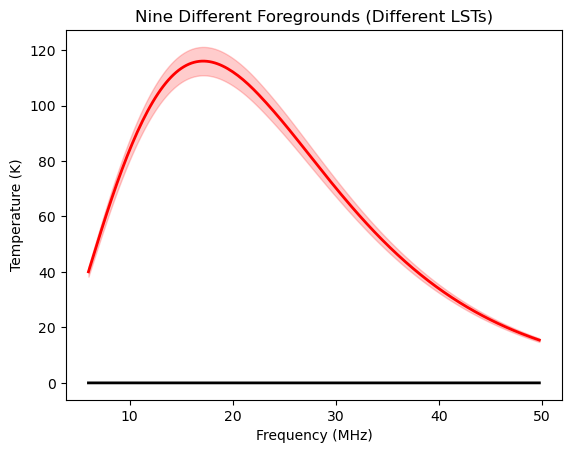

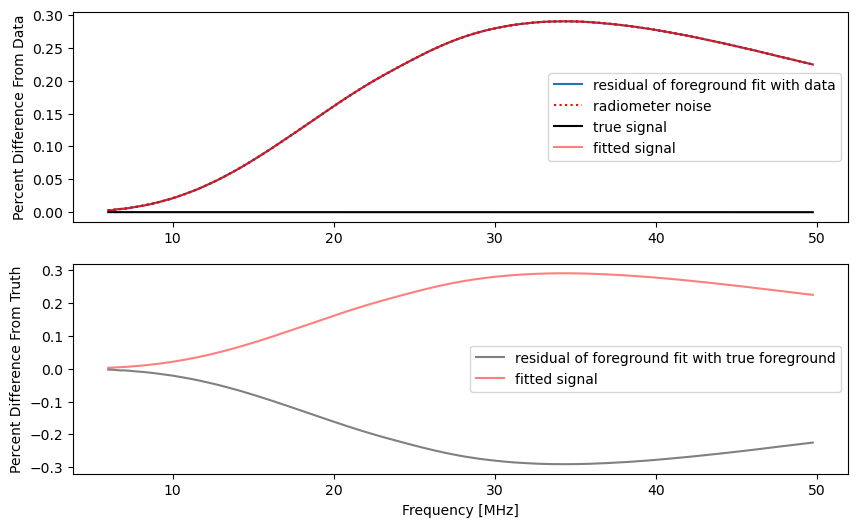

In [10]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:
Nb = 500
N = 500

IC = "DIC"

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  
# custom_parameter_range = np.array([[1,1.1],[3.4,3.41],[4.6,4.61]])# For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=500, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,500)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine Different Foregrounds (Different LSTs)', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 186.16it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 239.24it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 193.22it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 241.66it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 173.88it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 259.39it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 178.04it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 247.24it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 192.45it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 258.97it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 191.22it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 257.90it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 194.89it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 252.10it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 181.37it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 255.47it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 184.62it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 241.17it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 250000/250000 [00:01<00:00, 214193.65it/s]


Minimizing DIC over grid.
The MetaFitter chose 267 foreground terms based on DIC minimization.
The MetaFitter chose 2 signal terms based on DIC minimization.
-0.09562254448454373 Temperature of lowest point of the trough 
0.06603290384121678 Channel error at lowest point of the trough 
-1776484.5045482235 log evidence
1374.6685899410654 Chi Squared
0.882944108353794 Psi Squared
True PearsonRResult(statistic=-0.9975079016002666, pvalue=2.6655325571420817e-202)


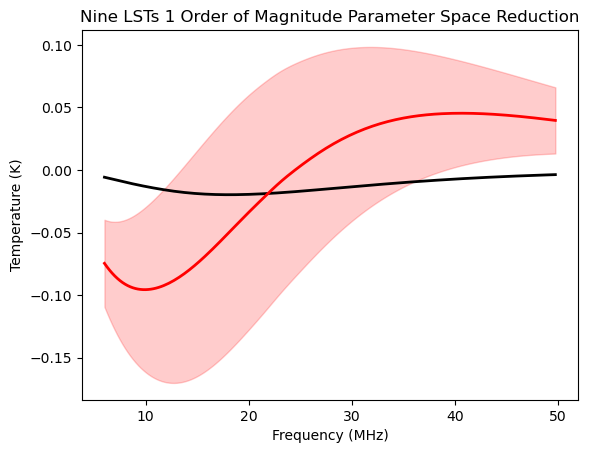

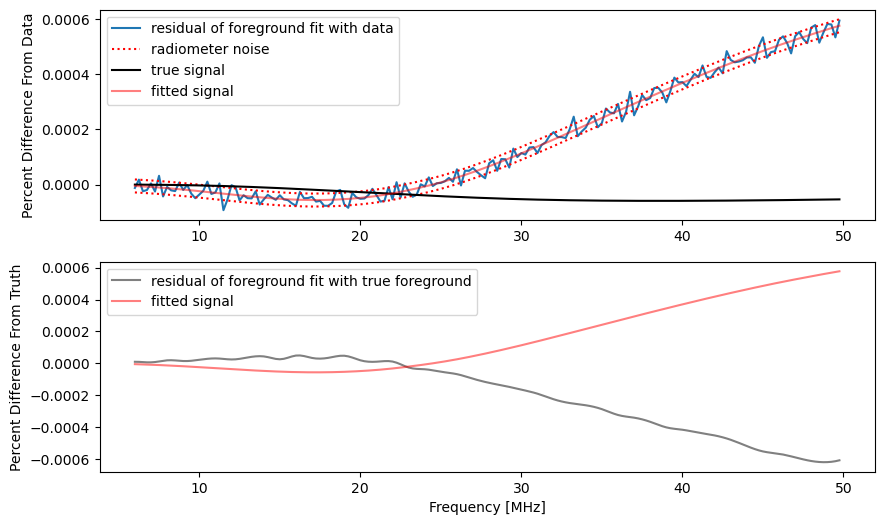

In [11]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 9 different foregrounds:

custom_parameter_range = np.array([[0.75,1.25],[3.3,3.5],[4.5,4.7]])  # For making a random foreground
parameter_variation = [0.005,0.0025,0.005]                         # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 1 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()


100%|██████████| 176/176 [00:00<00:00, 180.45it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 256.51it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 204.33it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 260.04it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 197.56it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 255.04it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 201.03it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 248.33it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 193.35it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 257.82it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 199.38it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 259.81it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 203.84it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 252.79it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 195.32it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 257.71it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 194.20it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:01<00:00, 252.81it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 250000/250000 [00:01<00:00, 225156.28it/s]


Minimizing DIC over grid.
The MetaFitter chose 238 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.014983998632116281 Temperature of lowest point of the trough 
0.04381576835571771 Channel error at lowest point of the trough 
59540.348802035965 log evidence
1409.2743914197517 Chi Squared
0.8902890405324249 Psi Squared
True PearsonRResult(statistic=0.6226813844127114, pvalue=2.798150229101114e-20)


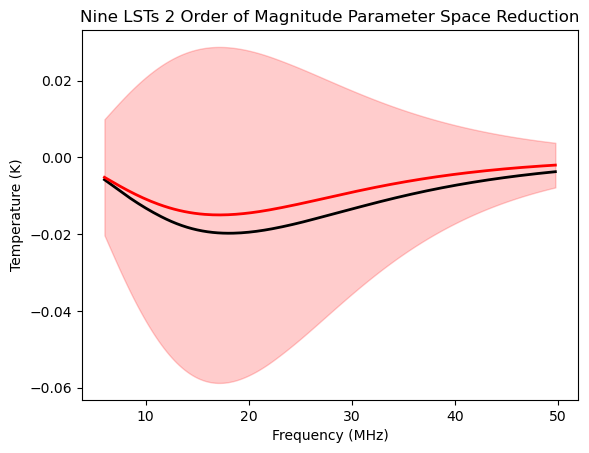

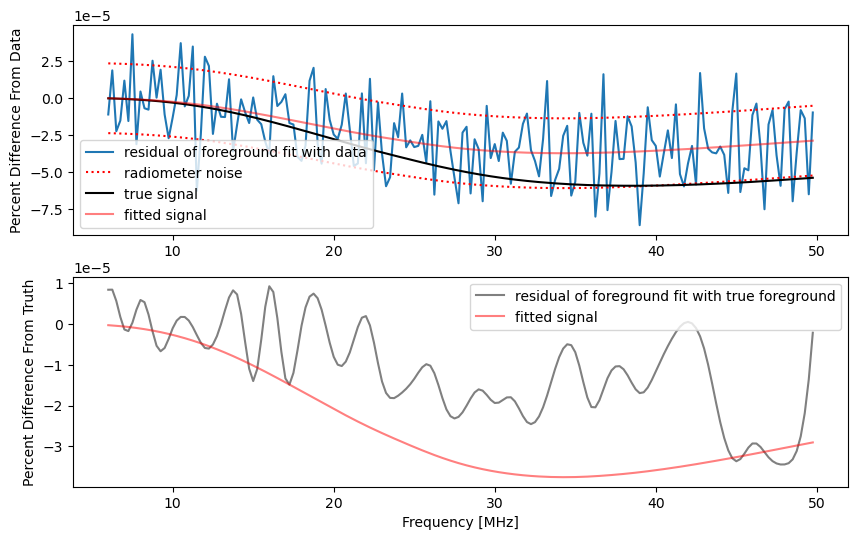

In [12]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]                           # For making a random foreground                        # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 2 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 178.61it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 243.87it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 175.25it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 224.81it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 147.49it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 243.04it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 198.54it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 255.78it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 168.79it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 231.24it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 187.55it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 256.44it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 197.29it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 256.93it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 202.02it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 259.02it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 202.80it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 260.67it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 250000/250000 [00:01<00:00, 232376.92it/s]


Minimizing DIC over grid.
The MetaFitter chose 159 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.012439883931931848 Temperature of lowest point of the trough 
0.018815007591952673 Channel error at lowest point of the trough 
52997.23564221024 log evidence
1471.3693265701854 Chi Squared
0.9816972097698669 Psi Squared
True PearsonRResult(statistic=0.7674164994705843, pvalue=2.0190810147279858e-35)


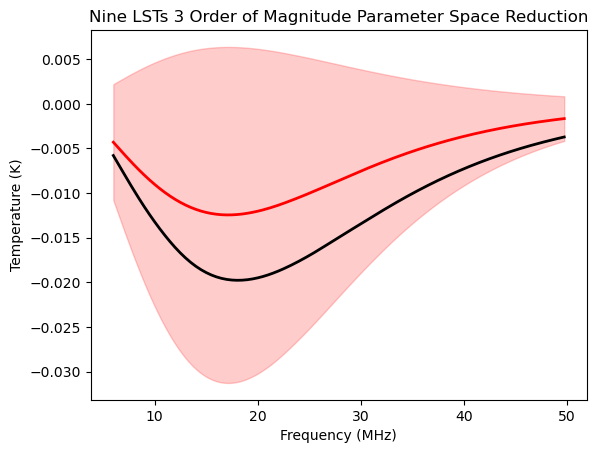

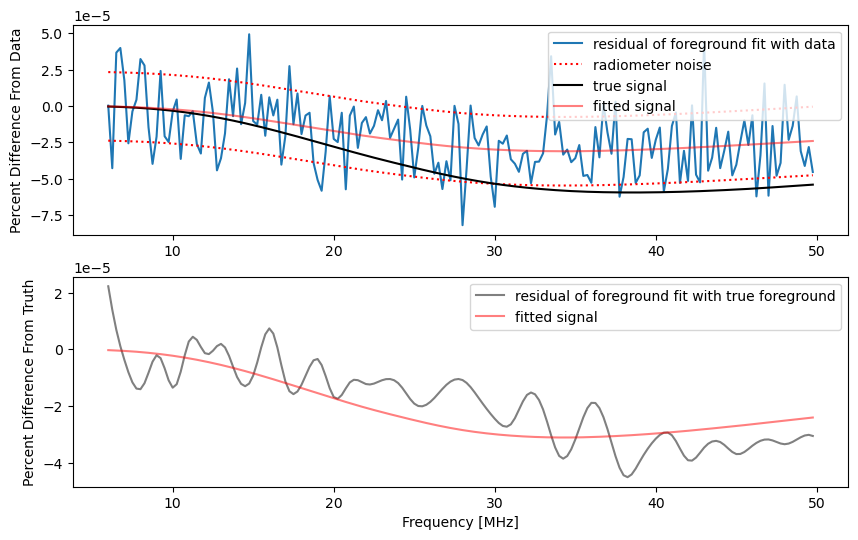

In [7]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9975,1.0025],[3.399,3.401],[4.599,4.609]])  # For making a random foreground
parameter_variation = [0.00005,0.000025,0.00005]                            # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9




# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 3 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 174.97it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 218.76it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 196.07it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 247.74it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 201.23it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 261.98it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 203.49it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 264.30it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 192.16it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 263.43it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 189.65it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 246.94it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 198.44it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 255.47it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 201.52it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 250.47it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 188.84it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:01<00:00, 263.21it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 250000/250000 [00:01<00:00, 234363.12it/s]


Minimizing DIC over grid.
The MetaFitter chose 84 foreground terms based on DIC minimization.
The MetaFitter chose 1 signal terms based on DIC minimization.
-0.021341795541836812 Temperature of lowest point of the trough 
0.005144586819359961 Channel error at lowest point of the trough 
-2756.853706606333 log evidence
1516.0241459109634 Chi Squared
1.0077476564676586 Psi Squared
True PearsonRResult(statistic=0.3812639941699014, pvalue=1.7839658722508587e-07)


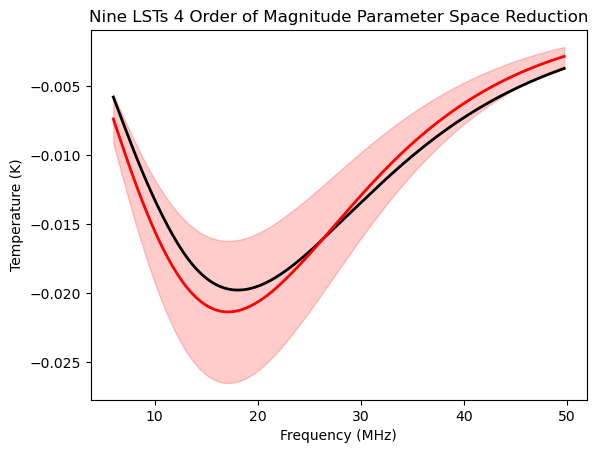

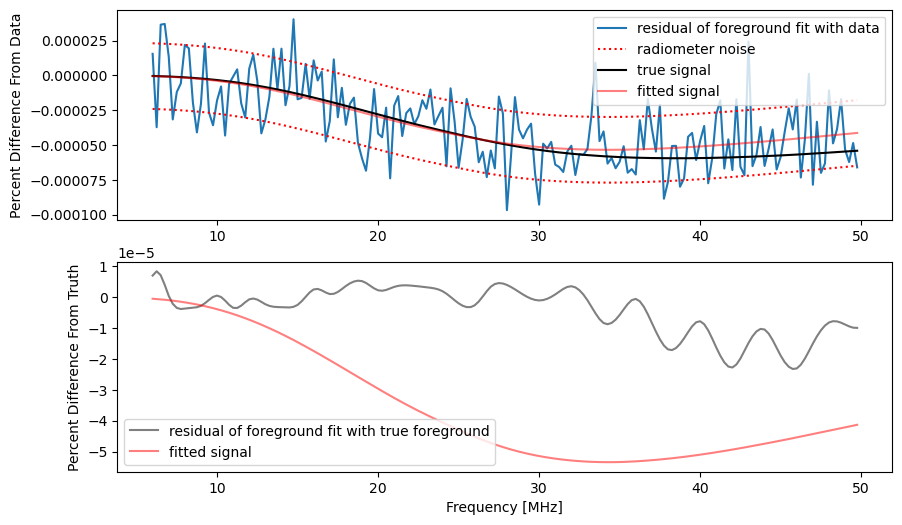

In [8]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6009]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]                             # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 4 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 177.47it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 244.61it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 193.17it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:01<00:00, 250.61it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 195.14it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:01<00:00, 253.54it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 171.30it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:01<00:00, 255.95it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 194.18it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 229.75it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 190.72it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 230.64it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 176.98it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 244.58it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 197.82it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.48it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 185.41it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 230.63it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 250000/250000 [00:01<00:00, 207551.56it/s]


Minimizing DIC over grid.
The MetaFitter chose 47 foreground terms based on DIC minimization.
The MetaFitter chose 2 signal terms based on DIC minimization.
-0.01859766747505782 Temperature of lowest point of the trough 
0.002731040674657846 Channel error at lowest point of the trough 
-2025.0105382610782 log evidence
1565.7808297165125 Chi Squared
1.0602477981451126 Psi Squared
True PearsonRResult(statistic=-0.37534581916237314, pvalue=2.8520661977365296e-07)


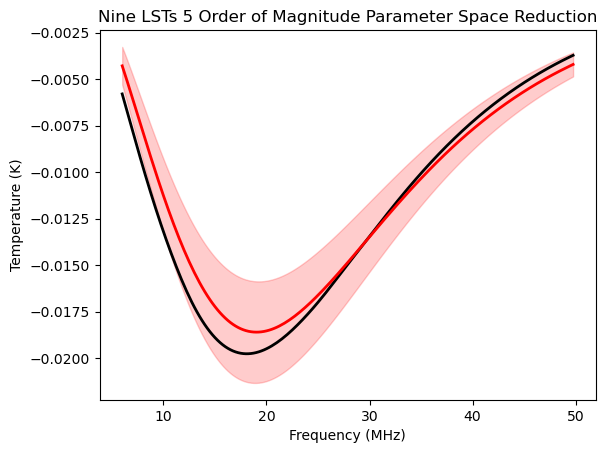

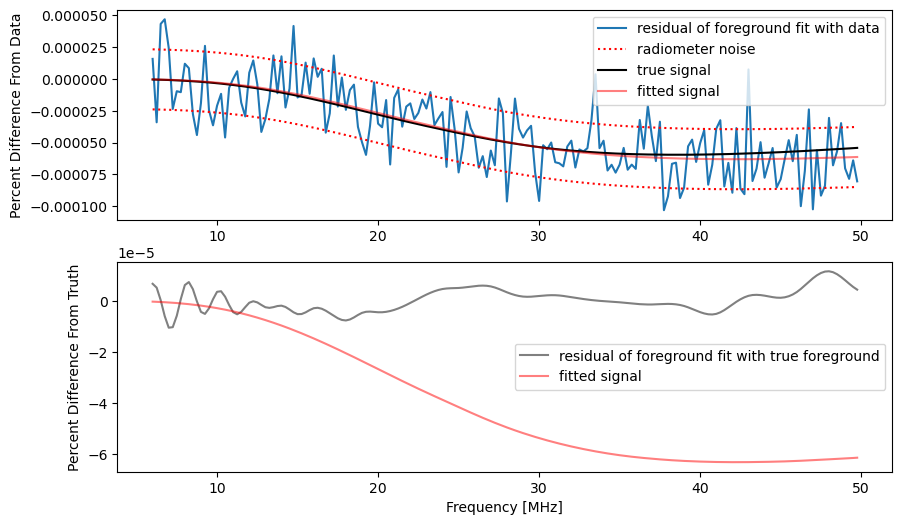

In [9]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60009]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                               # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 5 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 186.36it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 234.79it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 184.79it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:01<00:00, 256.37it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 192.11it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:01<00:00, 253.89it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 192.53it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:01<00:00, 260.43it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 199.39it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:01<00:00, 250.04it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 196.11it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 206.28it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 184.53it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.68it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.41it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 230.87it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.25it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 244.46it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 250000/250000 [00:01<00:00, 219139.79it/s]


Minimizing DIC over grid.
The MetaFitter chose 1 foreground terms based on DIC minimization.
The MetaFitter chose 3 signal terms based on DIC minimization.
-0.017179444972667362 Temperature of lowest point of the trough 
0.0017161692365687971 Channel error at lowest point of the trough 
-1157.2405300580908 log evidence
1598.3563484960055 Chi Squared
1.0637077376984756 Psi Squared
True PearsonRResult(statistic=0.6674584265501697, pvalue=4.709572175056107e-24)


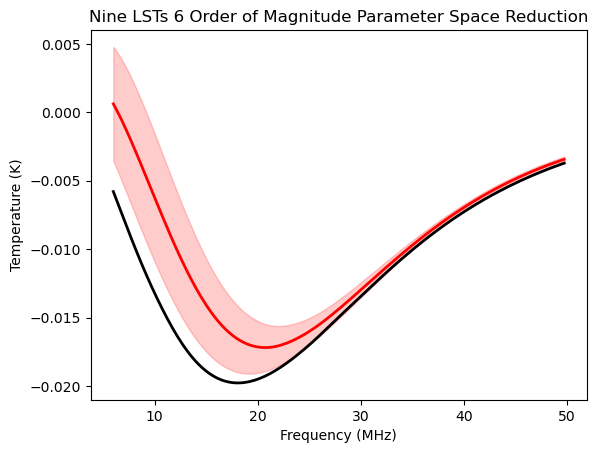

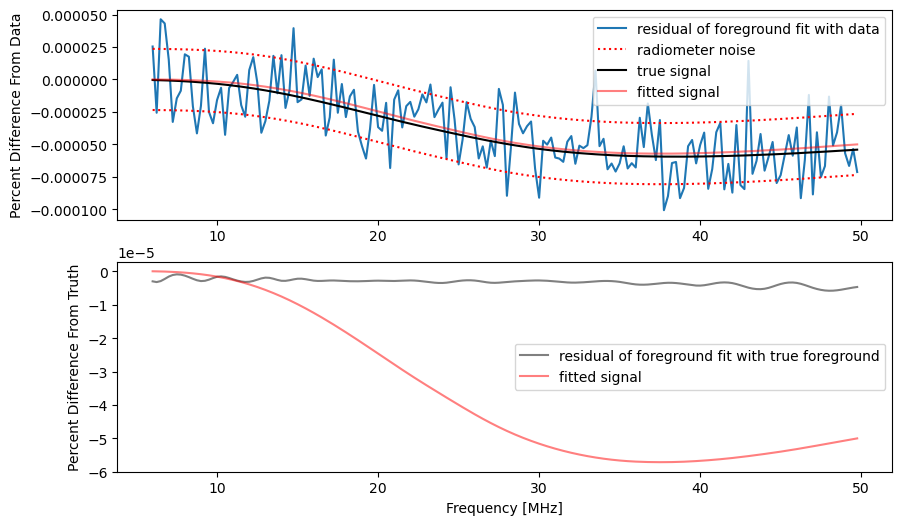

: 

In [ ]:
### 9 LSTs ### 

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9999975,1.0000025],[3.399999,3.400001],[4.599999,4.600009]])  # For making a random foreground
parameter_variation = [0.00000005,0.000000025,0.00000005]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 6 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

## 9 LST BPIC

100%|██████████| 176/176 [00:01<00:00, 116.87it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 241.59it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 124.86it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 252.60it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 128.10it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 249.06it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 123.47it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 244.70it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 123.87it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 242.97it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 117.75it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 206.46it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.30it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 236.77it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.66it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 238.99it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 119.50it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 236.78it/s]


[0.05, 0.025, 0.05]


100%|██████████| 250000/250000 [00:01<00:00, 219877.22it/s]


Minimizing BPIC over grid.
The MetaFitter chose 455 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
48.899655306640746 Temperature of lowest point of the trough 
0.9713379269110849 Channel error at lowest point of the trough 
-5029358746.573592 log evidence
35206.4738517853 Chi Squared
2656.7553236744475 Psi Squared
True PearsonRResult(statistic=-0.9999999789566139, pvalue=0.0)


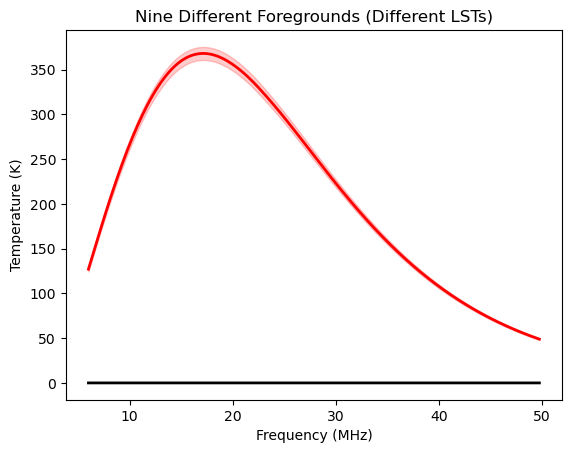

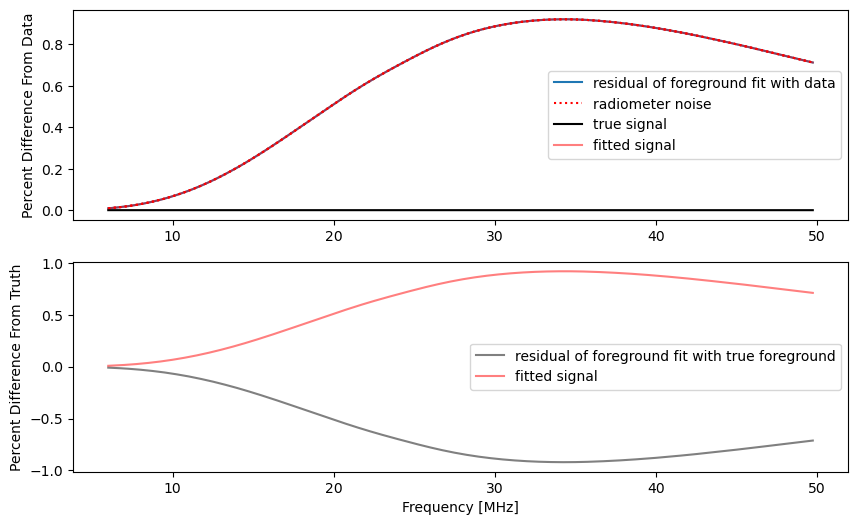

In [7]:
### 9 LSTs ###  ### Here ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

IC = "BPIC"

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  
# custom_parameter_range = np.array([[1,1.1],[3.4,3.41],[4.6,4.61]])# For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine Different Foregrounds (Different LSTs)', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 172.30it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 214.97it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 182.05it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 244.78it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 178.25it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 246.47it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 190.42it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 246.65it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 187.92it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 250.91it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 191.42it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 243.88it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 190.76it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 252.96it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 190.58it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 247.33it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 188.17it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 246.16it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 250000/250000 [00:01<00:00, 226725.66it/s]


Minimizing BPIC over grid.
The MetaFitter chose 258 foreground terms based on BPIC minimization.
The MetaFitter chose 3 signal terms based on BPIC minimization.
-0.8224948849207763 Temperature of lowest point of the trough 
0.39781388275563917 Channel error at lowest point of the trough 
-2513239.279442498 log evidence
1350.5998356727735 Chi Squared
0.8797181169080448 Psi Squared
True PearsonRResult(statistic=-0.999917767924845, pvalue=0.0)


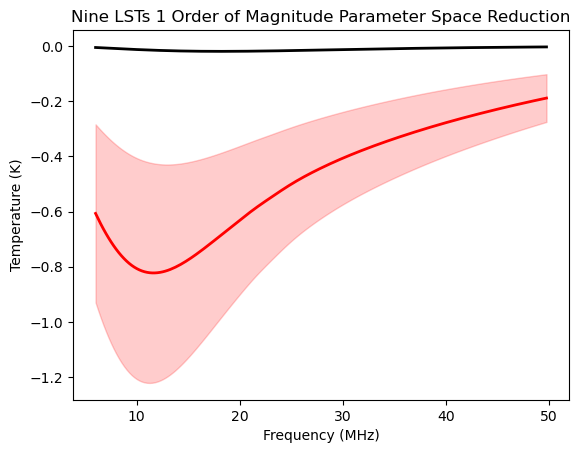

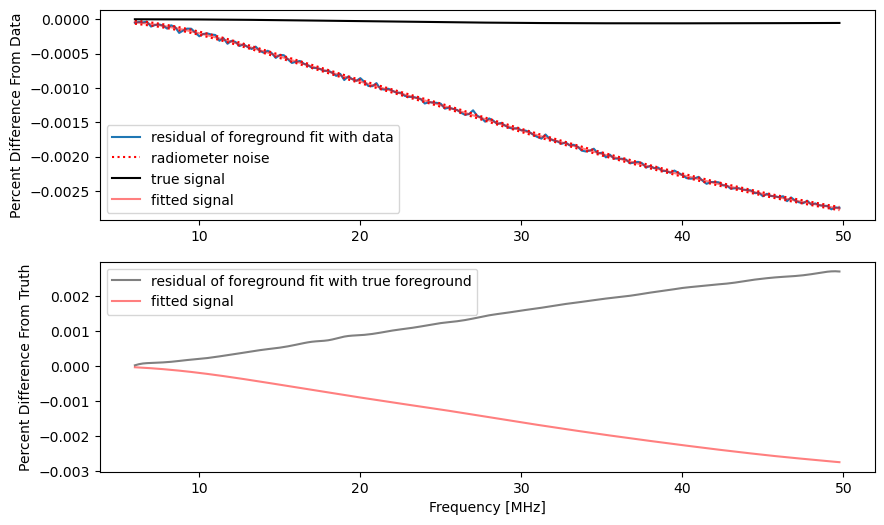

In [8]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.75,1.25],[3.3,3.5],[4.5,4.7]])  # For making a random foreground
parameter_variation = [0.005,0.0025,0.005]                         # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 1 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()


100%|██████████| 176/176 [00:01<00:00, 159.46it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 206.50it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 172.67it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 212.52it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 176.93it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 211.01it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 188.99it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 213.58it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 175.05it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 238.61it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 183.05it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 231.02it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 189.52it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 232.28it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 187.42it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 246.23it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 190.30it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 250.00it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 250000/250000 [00:01<00:00, 216183.27it/s]


Minimizing BPIC over grid.
The MetaFitter chose 234 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-0.05747944912610632 Temperature of lowest point of the trough 
0.041718371166873214 Channel error at lowest point of the trough 
148899.85327436772 log evidence
1372.0900797598501 Chi Squared
0.8874139649000655 Psi Squared
True PearsonRResult(statistic=-0.9357510367933948, pvalue=1.1214777646833808e-80)


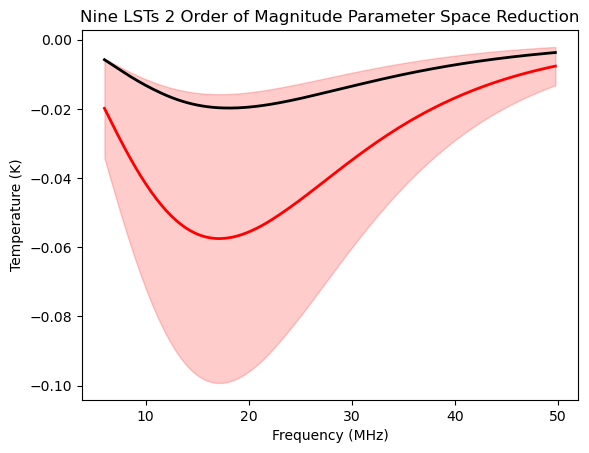

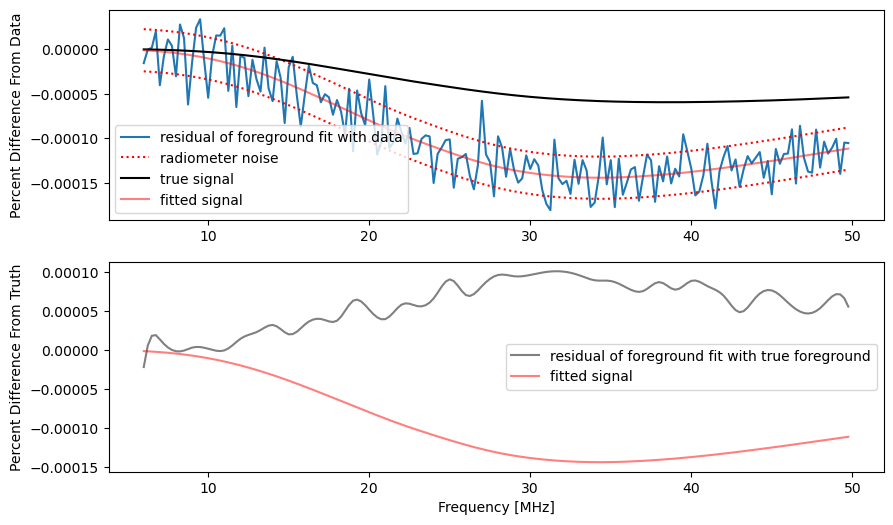

In [9]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]                           # For making a random foreground                        # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 2 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:01<00:00, 161.82it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 234.69it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 177.58it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 222.80it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 173.65it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 213.47it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 189.85it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 230.50it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 187.65it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 243.44it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 172.58it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 244.40it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 199.48it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 252.01it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 198.63it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 248.05it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 192.39it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:01<00:00, 252.04it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 250000/250000 [00:01<00:00, 229517.56it/s]


Minimizing BPIC over grid.
The MetaFitter chose 145 foreground terms based on BPIC minimization.
The MetaFitter chose 14 signal terms based on BPIC minimization.
-0.5532526032560515 Temperature of lowest point of the trough 
0.39456950258681733 Channel error at lowest point of the trough 
5976736.88321795 log evidence
1454.6190313723494 Chi Squared
0.9590462168759186 Psi Squared
True PearsonRResult(statistic=-0.9984634622450062, pvalue=1.484341037373159e-220)


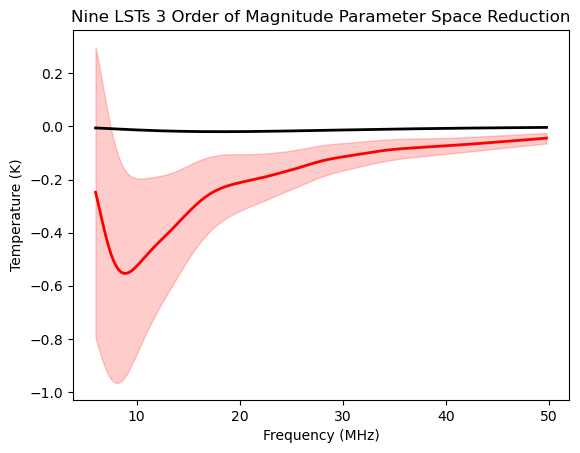

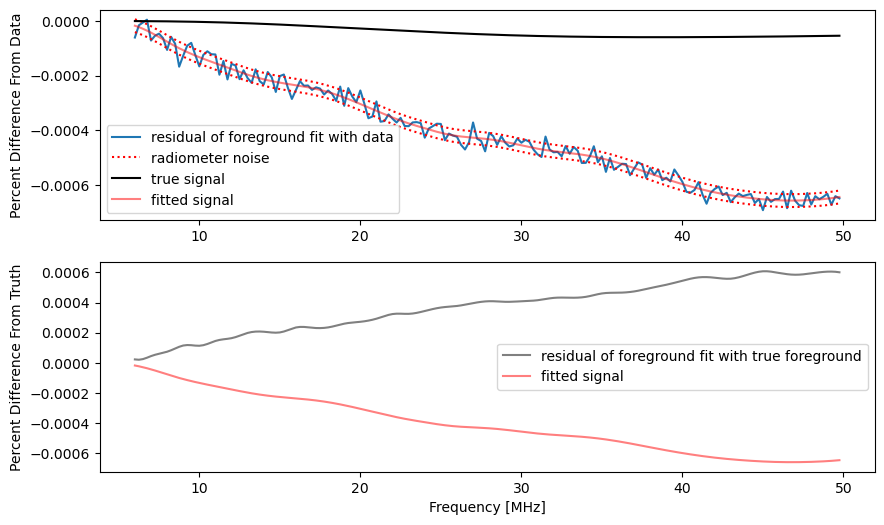

In [10]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9975,1.0025],[3.399,3.401],[4.599,4.609]])  # For making a random foreground
parameter_variation = [0.00005,0.000025,0.00005]                            # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9




# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 3 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 178.34it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.07it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 183.05it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 238.07it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 154.25it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 226.68it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 175.42it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 223.21it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 192.55it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.60it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 193.05it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 239.40it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 187.77it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 218.62it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 144.00it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.49it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 186.30it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.63it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 250000/250000 [00:01<00:00, 218569.59it/s]


Minimizing BPIC over grid.
The MetaFitter chose 71 foreground terms based on BPIC minimization.
The MetaFitter chose 1 signal terms based on BPIC minimization.
-0.024814251930652464 Temperature of lowest point of the trough 
0.004691722074989759 Channel error at lowest point of the trough 
-869.6618872724478 log evidence
1561.274863891353 Chi Squared
1.0414291706951502 Psi Squared
True PearsonRResult(statistic=-0.17281900912858747, pvalue=0.021810494970939853)


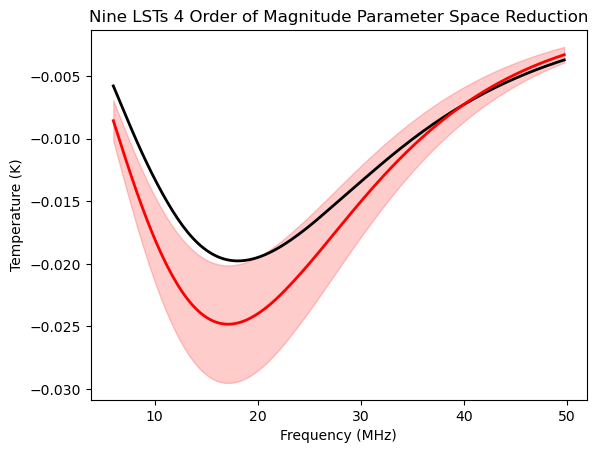

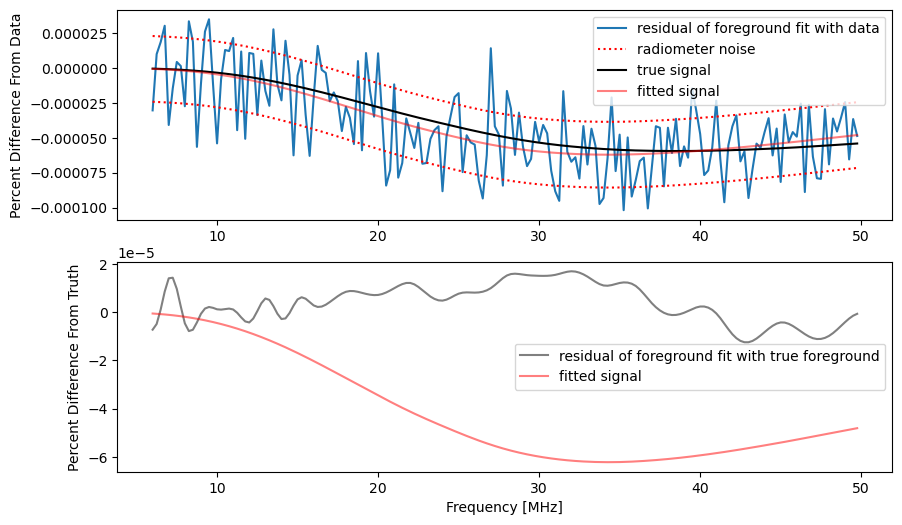

In [11]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6009]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]                             # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 4 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 177.88it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 229.58it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 182.88it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 227.02it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 182.63it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 242.34it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 194.46it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 241.13it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 196.13it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 210.04it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 157.74it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 231.98it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 188.01it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 197.64it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 186.87it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 230.12it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 181.33it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 238.62it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 250000/250000 [00:01<00:00, 214674.70it/s]


Minimizing BPIC over grid.
The MetaFitter chose 34 foreground terms based on BPIC minimization.
The MetaFitter chose 2 signal terms based on BPIC minimization.
-0.021969081738779365 Temperature of lowest point of the trough 
0.0021693044709200082 Channel error at lowest point of the trough 
-933.9571570858417 log evidence
1590.9251882856634 Chi Squared
1.0415907609378339 Psi Squared
True PearsonRResult(statistic=-0.21184752243958666, pvalue=0.00476422831182784)


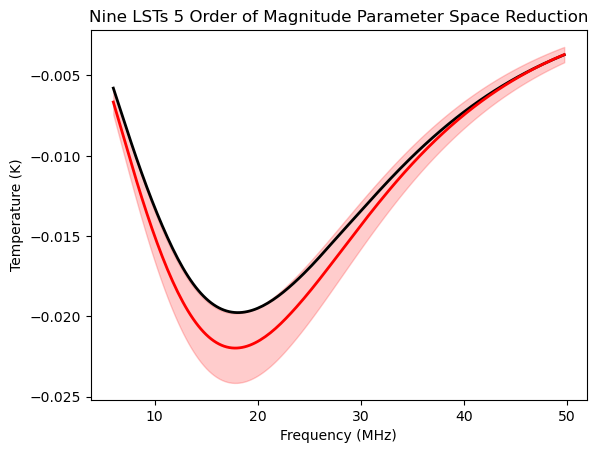

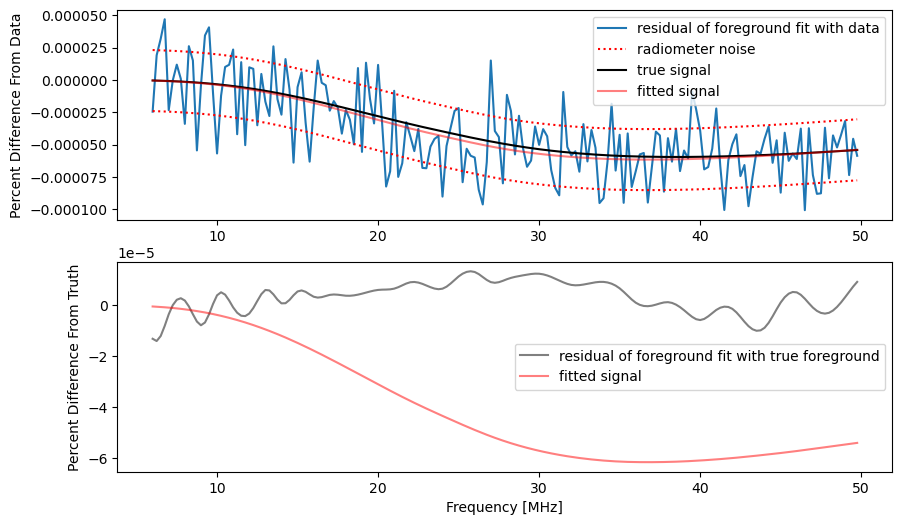

In [12]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60009]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                               # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 5 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

100%|██████████| 176/176 [00:00<00:00, 180.70it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 228.77it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 182.80it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 245.06it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 193.65it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 242.74it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 181.78it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 230.64it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 194.24it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 221.27it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 189.95it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 246.11it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 196.42it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 247.74it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 190.23it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 242.62it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 196.72it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 247.80it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 250000/250000 [00:01<00:00, 224787.52it/s]


Minimizing BPIC over grid.
The MetaFitter chose 1 foreground terms based on BPIC minimization.
The MetaFitter chose 2 signal terms based on BPIC minimization.
-0.020341516889129573 Temperature of lowest point of the trough 
0.0009790686112619792 Channel error at lowest point of the trough 
-786.0597300276676 log evidence
1594.6981571164629 Chi Squared
1.054981490869219 Psi Squared
True PearsonRResult(statistic=0.6927298918903245, pvalue=1.734748053557962e-26)


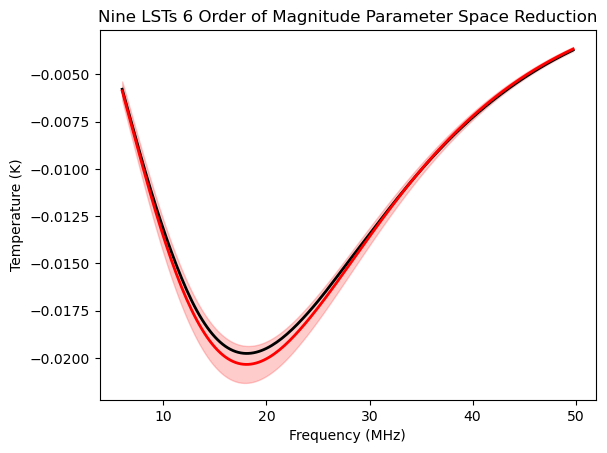

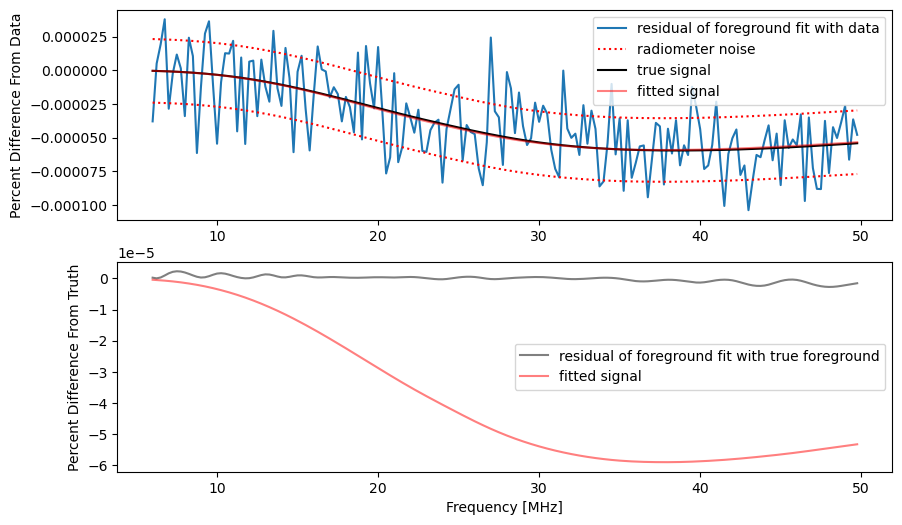

In [13]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9999975,1.0000025],[3.399999,3.400001],[4.599999,4.600009]])  # For making a random foreground
parameter_variation = [0.00000005,0.000000025,0.00000005]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(1,600)},
{'signal': np.arange(1,30)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
# priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 6 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

##  9 LSTs with Priors (and Bayesian Evidence)

In [17]:
Nb=500
N=500
IC = "log_evidence"

100%|██████████| 176/176 [00:01<00:00, 106.32it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 235.79it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 106.05it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 252.22it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 123.19it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 241.26it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 123.47it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 221.92it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 111.11it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 222.98it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 116.34it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 244.52it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 122.90it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:01<00:00, 251.91it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 124.91it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 239.36it/s]


[0.05, 0.025, 0.05]


100%|██████████| 176/176 [00:01<00:00, 127.06it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 247.75it/s]


[0.05, 0.025, 0.05]


100%|██████████| 250000/250000 [00:01<00:00, 212888.39it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 311 foreground terms based on log_evidence minimization.
The MetaFitter chose 26 signal terms based on log_evidence minimization.
-0.9294247822294204 Temperature of lowest point of the trough 
0.016323550416095633 Channel error at lowest point of the trough 
-6268337.65333138 log evidence
11976227.545582928 Chi Squared
526127471.2101591 Psi Squared
True PearsonRResult(statistic=-0.3536164824204882, pvalue=1.4772453269173016e-06)


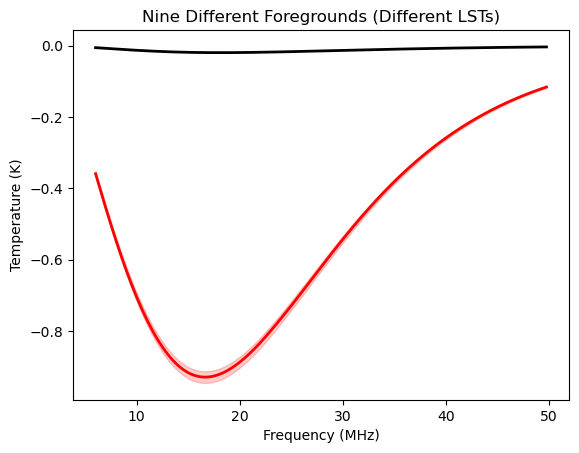

(0, 0, 0)


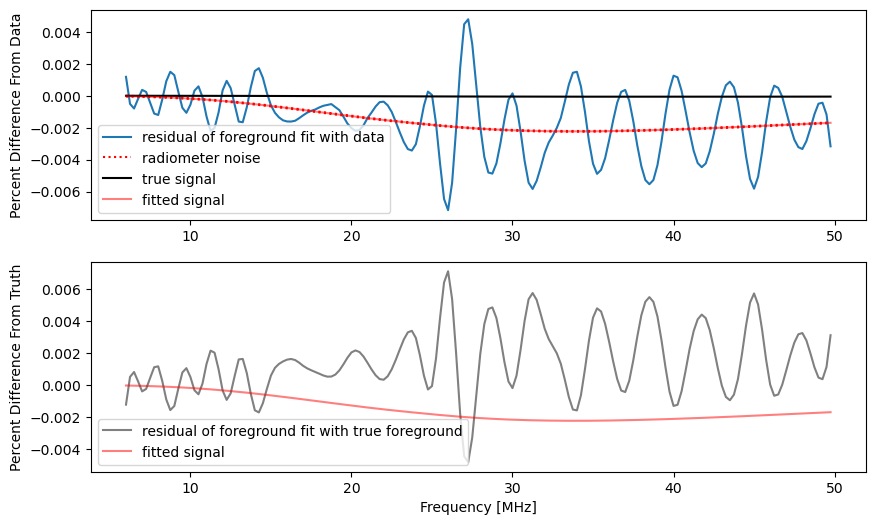

In [35]:
### 9 LSTs ###  ### Here ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  
# custom_parameter_range = np.array([[1,1.1],[3.4,3.41],[4.6,4.61]])# For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(311,312)},
{'signal': np.arange(26,27)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine Different Foregrounds (Different LSTs)', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 141.25it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 219.91it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 163.09it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 235.00it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 175.32it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 218.31it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 172.00it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 208.79it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 176.64it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 249.22it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 183.36it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 243.42it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 189.76it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:01<00:00, 250.02it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:00<00:00, 183.79it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 237.40it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 176/176 [00:01<00:00, 174.37it/s]


[[0.75 1.25]
 [3.3  3.5 ]
 [4.5  4.7 ]]


100%|██████████| 500/500 [00:02<00:00, 233.42it/s]


[0.005, 0.0025, 0.005]


100%|██████████| 250000/250000 [00:01<00:00, 215748.57it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 238 foreground terms based on log_evidence minimization.
The MetaFitter chose 27 signal terms based on log_evidence minimization.
-0.019344735293397267 Temperature of lowest point of the trough 
0.015214264588520097 Channel error at lowest point of the trough 
-1194086.5696754104 log evidence
5082.974514088859 Chi Squared
28.298727617210748 Psi Squared
True PearsonRResult(statistic=0.11137842910063636, pvalue=0.14111383022056292)


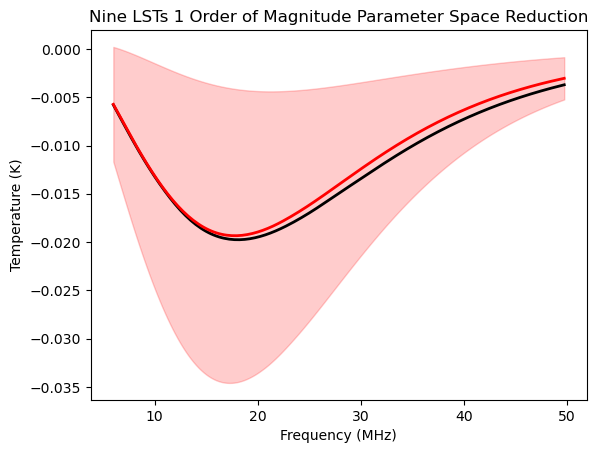

(0, 0, 0)


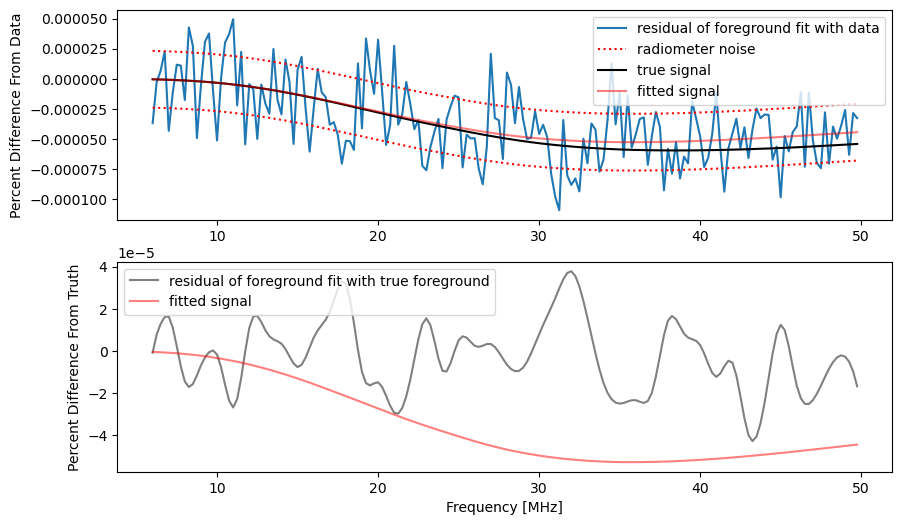

In [36]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.75,1.25],[3.3,3.5],[4.5,4.7]])  # For making a random foreground
parameter_variation = [0.005,0.0025,0.005]                         # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(238,239)},
{'signal': np.arange(27,28)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 1 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 169.64it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 186.77it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 146.23it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 195.23it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 147.30it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 178.59it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 168.04it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 234.18it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 179.68it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 211.66it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 178.97it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 234.40it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 182.22it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 200.30it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:01<00:00, 159.86it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 247.11it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 176/176 [00:00<00:00, 185.53it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 500/500 [00:02<00:00, 232.17it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 250000/250000 [00:01<00:00, 215461.21it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 203 foreground terms based on log_evidence minimization.
The MetaFitter chose 26 signal terms based on log_evidence minimization.
-0.01981978170907253 Temperature of lowest point of the trough 
0.014578558747086754 Channel error at lowest point of the trough 
10620030.44013973 log evidence
1511.5640218606623 Chi Squared
0.9628053672387988 Psi Squared
True PearsonRResult(statistic=0.23858242138599745, pvalue=0.001428761861538912)


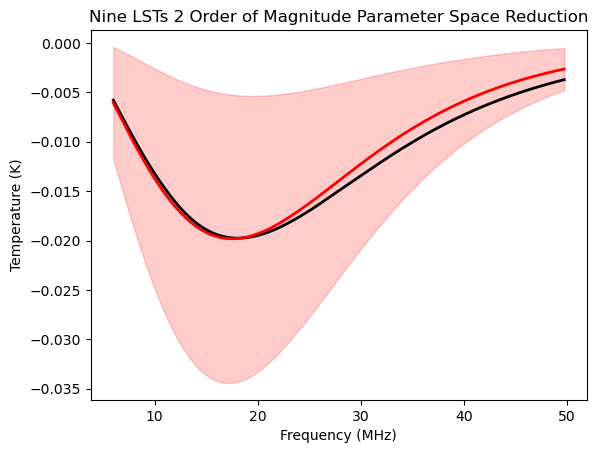

(0, 0, 0)


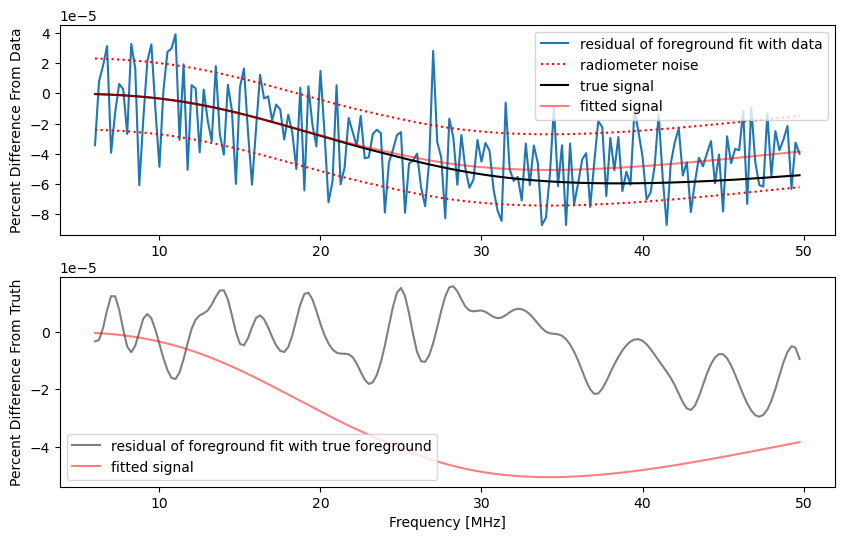

In [37]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]                           # For making a random foreground                        # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(203,204)},
{'signal': np.arange(26,27)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 2 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 144.74it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 191.95it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 154.61it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 197.19it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 164.39it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 214.46it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 151.69it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 221.87it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 173.01it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 218.12it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:00<00:00, 177.82it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 188.48it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 131.20it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 194.54it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 166.01it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 204.88it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 176/176 [00:01<00:00, 162.90it/s]


[[0.9975 1.0025]
 [3.399  3.401 ]
 [4.599  4.609 ]]


100%|██████████| 500/500 [00:02<00:00, 209.68it/s]


[5e-05, 2.5e-05, 5e-05]


100%|██████████| 250000/250000 [00:01<00:00, 187320.27it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 155 foreground terms based on log_evidence minimization.
The MetaFitter chose 26 signal terms based on log_evidence minimization.
-0.022918528228723953 Temperature of lowest point of the trough 
0.011707745045259208 Channel error at lowest point of the trough 
947344.4231416206 log evidence
1477.313034524705 Chi Squared
0.9633926199442354 Psi Squared
True PearsonRResult(statistic=0.015404023085152242, pvalue=0.8392027745850859)


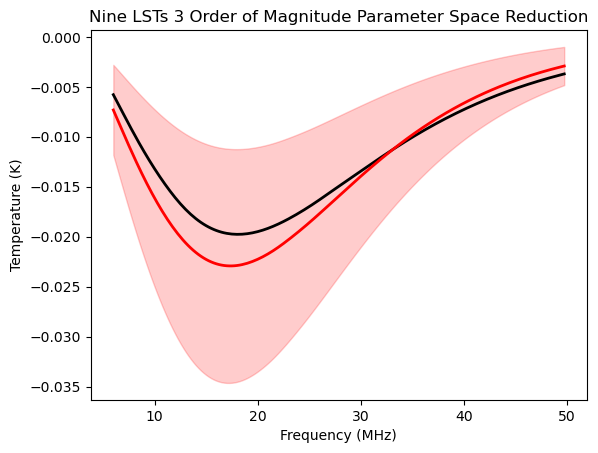

(0, 0, 0)


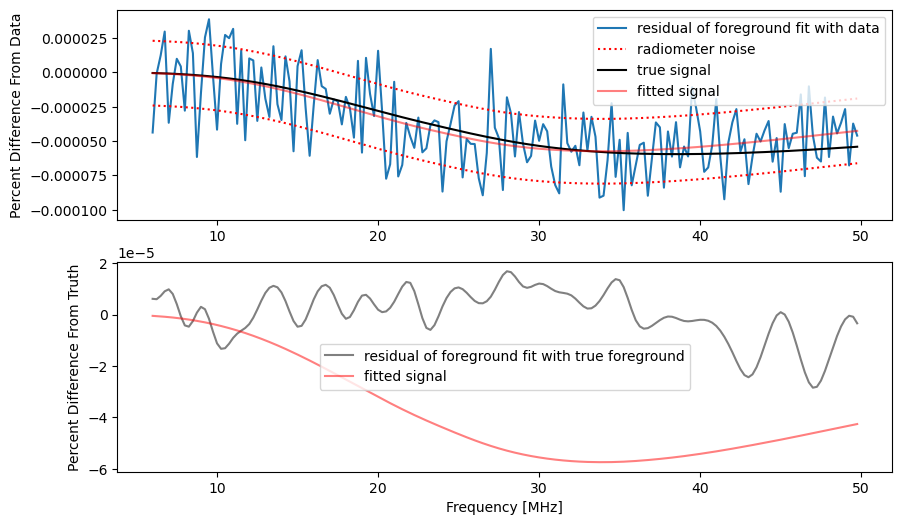

In [38]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9975,1.0025],[3.399,3.401],[4.599,4.609]])  # For making a random foreground
parameter_variation = [0.00005,0.000025,0.00005]                            # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9




# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(155,156)},
{'signal': np.arange(26,27)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 3 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 154.17it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 190.50it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 146.41it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 223.05it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 170.74it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 207.73it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 172.75it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 238.51it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 179.86it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 237.42it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 189.80it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 235.80it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 182.73it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 234.02it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:01<00:00, 173.70it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 236.65it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 176/176 [00:00<00:00, 184.71it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6009 ]]


100%|██████████| 500/500 [00:02<00:00, 231.75it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 250000/250000 [00:01<00:00, 172028.73it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 179 foreground terms based on log_evidence minimization.
The MetaFitter chose 36 signal terms based on log_evidence minimization.
-0.023035287767380827 Temperature of lowest point of the trough 
0.013797625226198833 Channel error at lowest point of the trough 
-84839715.79825912 log evidence
1473.6392996298318 Chi Squared
0.9322686655767126 Psi Squared
True PearsonRResult(statistic=-0.07251966037500743, pvalue=0.33882640388356394)


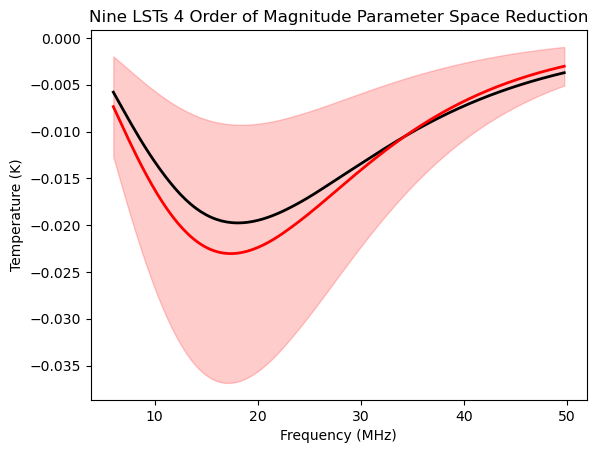

(0, 0, 0)


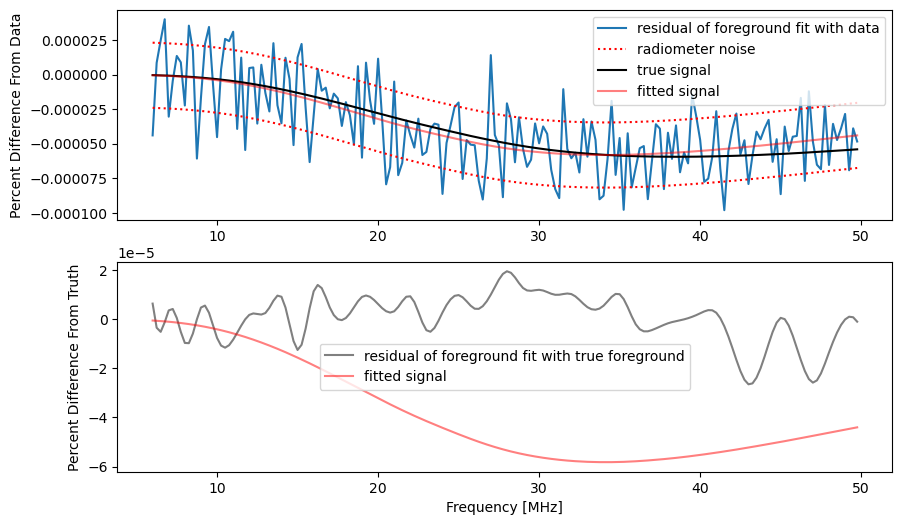

In [39]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6009]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]                             # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(179,180)},
{'signal': np.arange(36,37)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 4 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 158.64it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 176.69it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 150.54it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 198.26it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 152.78it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 226.74it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 133.17it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 226.00it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 154.57it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 186.07it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 141.74it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 225.94it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 139.85it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.56it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:00<00:00, 187.10it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 229.70it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 176/176 [00:01<00:00, 175.24it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60009 ]]


100%|██████████| 500/500 [00:02<00:00, 232.48it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 250000/250000 [00:01<00:00, 184658.52it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 287 foreground terms based on log_evidence minimization.
The MetaFitter chose 25 signal terms based on log_evidence minimization.
-0.00999145030997445 Temperature of lowest point of the trough 
0.016055158500190892 Channel error at lowest point of the trough 
860813.1768546653 log evidence
1327.7228484522711 Chi Squared
0.8859149298692031 Psi Squared
True PearsonRResult(statistic=0.6989636064426948, pvalue=3.9802313780870675e-27)


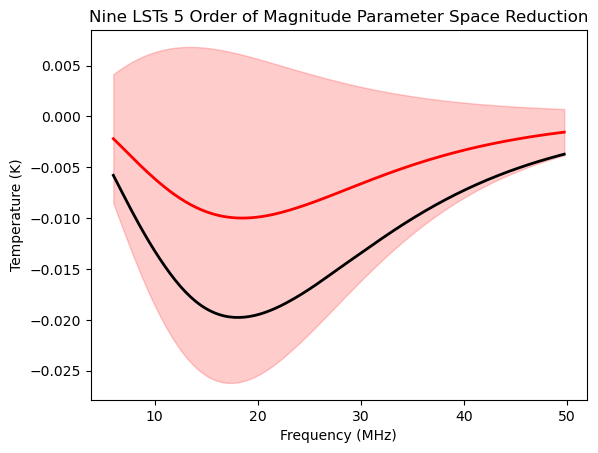

(0, 0, 0)


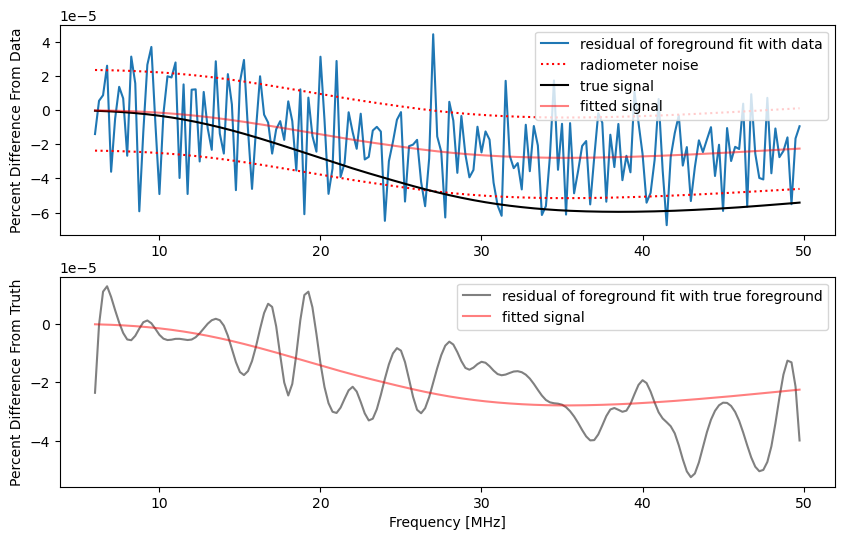

In [40]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60009]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                               # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(287,288)},
{'signal': np.arange(25,26)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 5 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

100%|██████████| 176/176 [00:01<00:00, 155.93it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 200.64it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:01<00:00, 171.14it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 215.39it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 181.10it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 222.26it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 177.12it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 227.92it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:01<00:00, 169.94it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 236.43it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.19it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 222.33it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 180.06it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 233.70it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 184.63it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 245.79it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 176/176 [00:00<00:00, 185.05it/s]


[[0.9999975 1.0000025]
 [3.399999  3.400001 ]
 [4.599999  4.600009 ]]


100%|██████████| 500/500 [00:02<00:00, 242.68it/s]


[5e-08, 2.5e-08, 5e-08]


100%|██████████| 250000/250000 [00:01<00:00, 210683.42it/s]


Minimizing log_evidence over grid.
The MetaFitter chose 234 foreground terms based on log_evidence minimization.
The MetaFitter chose 38 signal terms based on log_evidence minimization.
-0.013091022450582612 Temperature of lowest point of the trough 
0.015164084716817338 Channel error at lowest point of the trough 
-10323463.826277515 log evidence
1385.1748933022345 Chi Squared
0.9036964991129667 Psi Squared
True PearsonRResult(statistic=0.5903650329361367, pvalue=6.519099174694068e-18)


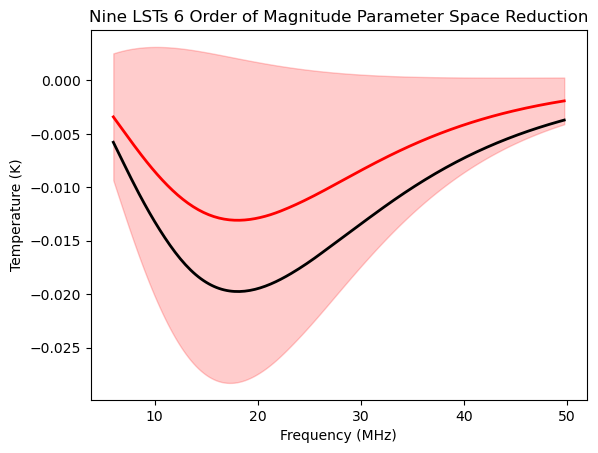

(0, 0, 0)


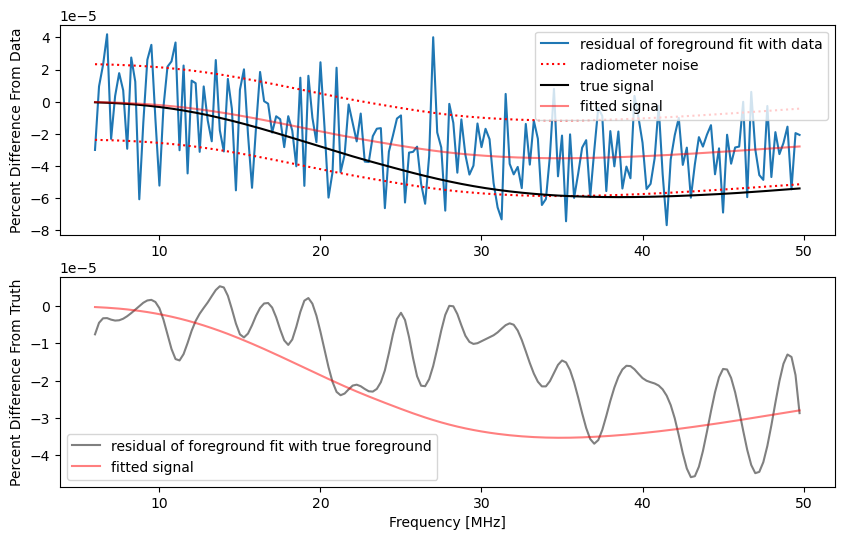

In [41]:
### 9 LSTs ###

## Creates a training set with varied foreground and beams for all 4 different foregrounds:

custom_parameter_range = np.array([[0.9999975,1.0000025],[3.399999,3.400001],[4.599999,4.600009]])  # For making a random foreground
parameter_variation = [0.00000005,0.000000025,0.00000005]                           # For making a random foreground
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
# custom_parameter_range = np.array([[1,1.1],[3.4,3.5],[4.6,4.7]])
# custom_parameter_range = np.array([[0.995,1.005],[3.3997,3.40027],[4.598,4.60128]])
# parameter_variation = [0.0002,0.0001,0.0002]
# parameter_variation = [0,0,0]
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)


n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_1 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_1[0],rms_mean,rms_std,foreground_run_set_1[3],foreground_run_set_1[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 2

## Creates a training set with varied foreground and beams:

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_2 = np.zeros((len(varied_regolith_training_set_raw_2),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_2)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_2[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_2[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_2 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_2[0],rms_mean,rms_std,foreground_run_set_2[3],foreground_run_set_2[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 3

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_3 = np.zeros((len(varied_regolith_training_set_raw_3),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_3)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_3[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_3[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_3 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_3[0],rms_mean,rms_std,foreground_run_set_3[3],foreground_run_set_3[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 4

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_4 = np.zeros((len(varied_regolith_training_set_raw_4),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_4)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_4[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_4[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_4 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values =py21cmsig.narrowed_training_set(simulation_test_beam_4[0],rms_mean,rms_std,foreground_run_set_4[3],foreground_run_set_4[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 5

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_5 = np.zeros((len(varied_regolith_training_set_raw_5),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_5)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_5[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_5[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_5 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_5[0],rms_mean,rms_std,foreground_run_set_5[3],foreground_run_set_5[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 6

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_6 = np.zeros((len(varied_regolith_training_set_raw_6),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_6)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_6[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_6[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_6 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_6[0],rms_mean,rms_std,foreground_run_set_6[3],foreground_run_set_6[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 7

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_7 = np.zeros((len(varied_regolith_training_set_raw_7),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_7)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_7[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_7[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_7 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_7[0],rms_mean,rms_std,foreground_run_set_7[3],foreground_run_set_7[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 8

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_8 = np.zeros((len(varied_regolith_training_set_raw_8),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_8)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_8[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_8[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_8 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions, \
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_8[0],rms_mean,rms_std,foreground_run_set_8[3],foreground_run_set_8[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

## Foreground 9

## Creates a training set with varied foreground and beams:


## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set_9 = np.zeros((len(varied_regolith_training_set_raw_9),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw_9)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw_9[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB_9[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps


determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set_9 = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam_9[0],rms_mean,rms_std,foreground_run_set_9[3],foreground_run_set_9[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)

### Combine them all
foreground_run_combined_9 = np.zeros((Nb*N,9,len(frequencies)))
foreground_run_combined_9[:,0,:] = foreground_run_set_1[3]
foreground_run_combined_9[:,1,:] = foreground_run_set_2[3]
foreground_run_combined_9[:,2,:] = foreground_run_set_3[3]
foreground_run_combined_9[:,3,:] = foreground_run_set_4[3]
foreground_run_combined_9[:,4,:] = foreground_run_set_5[3]
foreground_run_combined_9[:,5,:] = foreground_run_set_6[3]
foreground_run_combined_9[:,6,:] = foreground_run_set_7[3]
foreground_run_combined_9[:,7,:] = foreground_run_set_8[3]
foreground_run_combined_9[:,8,:] = foreground_run_set_9[3]
# foreground_run_combined = np.concatenate((foreground_run_set_1[3],foreground_run_set_2[3],foreground_run_set_3[3],foreground_run_set_4[3]),axis=0)

# #Let's first start by combining the two arrays for the two separate signals:
fg_training_set = copy.deepcopy(foreground_run_combined_9)
flattened_foreground_training_set = np.reshape(fg_training_set, (len(fg_training_set), -1))
signal_training_set_4LST = DMAN_training_set

total_signal = np.zeros((9,len(frequencies)))
total_signal[0,:] = simulation_test_beam_1[0]
total_signal[1,:] = simulation_test_beam_2[0]
total_signal[2,:] = simulation_test_beam_3[0]
total_signal[3,:] = simulation_test_beam_4[0]
total_signal[4,:] = simulation_test_beam_5[0]
total_signal[5,:] = simulation_test_beam_6[0]
total_signal[6,:] = simulation_test_beam_7[0]
total_signal[7,:] = simulation_test_beam_8[0]
total_signal[8,:] = simulation_test_beam_9[0]

total_noise = np.zeros((9,len(frequencies)))
noise_level_1 = sigT(simulation_test_beam_1[0],dnu,dt)
noise_level_2 = sigT(simulation_test_beam_2[0],dnu,dt)
noise_level_3 = sigT(simulation_test_beam_3[0],dnu,dt)
noise_level_4 = sigT(simulation_test_beam_4[0],dnu,dt)
noise_level_5 = sigT(simulation_test_beam_5[0],dnu,dt)
noise_level_6 = sigT(simulation_test_beam_6[0],dnu,dt)
noise_level_7 = sigT(simulation_test_beam_7[0],dnu,dt)
noise_level_8 = sigT(simulation_test_beam_8[0],dnu,dt)
noise_level_9 = sigT(simulation_test_beam_9[0],dnu,dt)
total_noise[0,:] = noise_level_1
total_noise[1,:] = noise_level_2
total_noise[2,:] = noise_level_3
total_noise[3,:] = noise_level_4
total_noise[4,:] = noise_level_5
total_noise[5,:] = noise_level_6
total_noise[6,:] = noise_level_7
total_noise[7,:] = noise_level_8
total_noise[8,:] = noise_level_9



# pylinex requires 1D arrays, so let's flatten the noise_level and temperatures matrices (i.e. collapse the spectra)
temperatures_flat = total_signal.flatten()
noise_level_flat = total_noise.flatten()

# same as in Problem 3, let's use PowerLawTimesLogPolynomialModel for the foreground and a Gaussian for the signal


# across the 8 spectra, the signal is the same, but the foreground changes
# so, we have to make a different basis vector for each of the foreground spectra, but one basis for the sinal
names = ['foreground','signal']

                  # to transform the basis vectors from one space to another (e.g. into the data space), we use the Expander objects. 
                  # for the foreground, we will use PadExpander, which pads each foreground basis vector with zeros for the other spectra
                  # for the signal, we will use RepeatExpander, which expands vectors by repeating them multiple times
                  # (i.e. the signal is constant over the 8 pointings)

bases = [TrainedBasis(flattened_foreground_training_set,num_basis_vectors=600, expander=NullExpander()),\
TrainedBasis(signal_training_set_4LST,num_basis_vectors=40, expander=RepeatExpander(9))]
bases[0].generate_gaussian_prior()
bases[1].generate_gaussian_prior()

# define BasisSum object for pylinex's Fitter class 
# again using multiple bases, 8 for the foreground and one for the signal Gaussian
basis_sum = BasisSum(names, bases)

# same as in Problems 2 and 3,
# we optimize the number of terms by minimizing the Bayesian predictive information criterion (BPIC)
quantity = AttributeQuantity(IC)

# now set the number of terms to search numerically to minimize the BPIC
# choosing between 1 and 10 terms for each of the foregrounds, and 1 term for the signal
# placing the foreground spectra in the same dictionary,
# so that MetaFitter knows each will use the same number of terms (decreasing number of fits to perform)
dimension = [{"foreground": np.arange(234,235)},
{'signal': np.arange(38,39)}]

# now use MetaFitter to perform fits over the grid and choose the optimal fit based on minimizing the BPIC
priors = {"signal_prior" : bases[1].gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures_flat, noise_level_flat, quantity,\
quantity.name, *dimension,**priors)

# grab the Fitter object that corresponds to the fit that minimized the BPIC statistic
fitter_9 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_9.sizes['foreground']
num_signal_terms = fitter_9.sizes["signal"]
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_9.subbasis_channel_mean("signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_9.subbasis_channel_error("signal")[np.where(fitter_9.subbasis_channel_mean("signal")==fitter_9.subbasis_channel_mean("signal").min())][0]} Channel error at lowest point of the trough ")
print(f"{fitter_9.log_evidence} log evidence")
print(f"{fitter_9.chi_squared} Chi Squared")
print(f"{fitter_9.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2],(fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2])/simulation_test_beam_1[2])
print(f"True {pearsonr}")
fitter_9.plot_subbasis_fit(nsigma=1, name='signal', x_values=frequencies,\
colors='r', xlabel='Frequency (MHz)', ylabel='Temperature (K)',\
title='Nine LSTs 6 Order of Magnitude Parameter Space Reduction', show=True,true_curve = simulation_test_beam_1[1])


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 6))
plt.subplot(2,1,1)
plt.plot(frequencies,(simulation_test_beam_1[0]-fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)])/simulation_test_beam_1[0]*100,label="residual of foreground fit with data")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")+sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red",ls=":" ,label="radiometer noise")
plt.plot(frequencies,(fitter_9.subbasis_channel_mean("signal")-sigT(simulation_test_beam_1[0],dnu,dt))/simulation_test_beam_1[0]*100,color="red", ls=":")
plt.plot(frequencies,simulation_test_beam_1[1]/simulation_test_beam_1[0]*100,label="true signal",c="black")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[0]*100,label="fitted signal",alpha=0.5,c='red')
plt.ylabel("Percent Difference From Data")

plt.legend()

# Plots a handy plot of the true foreground residual from the simulation minus the foreground fit compared to the signal fit
# Good for identifying degeneracy by eye (pearson r is quantifying this)
plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_9.subbasis_channel_mean("foreground")[0:len(frequencies)]-simulation_test_beam_1[2]))/simulation_test_beam_1[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,fitter_9.subbasis_channel_mean("signal")/simulation_test_beam_1[2]*100,c="red",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Percent Difference From Truth")
plt.legend()

log_evidence_array=np.array(meta_fitter.grids)
index=np.argmax(log_evidence_array)
print(np.unravel_index(index,log_evidence_array.shape))

In [15]:
plt.plot((foreground_run_set[3][0]-varied_regolith_training_set[1])/varied_regolith_training_set[0]*100)

NameError: name 'foreground_run_set' is not defined

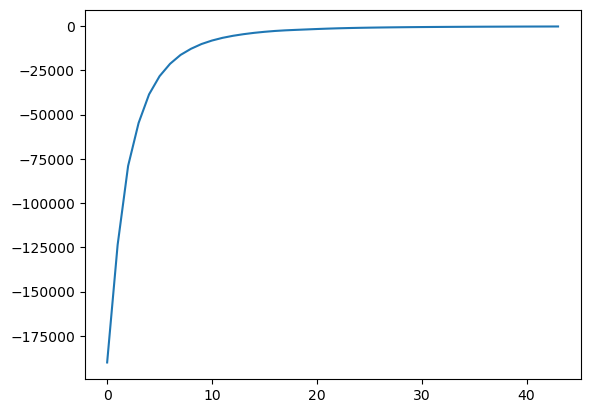

In [ ]:
plt.plot(varied_regolith_training_set_raw[1][0][6:]-simulation_test_beam_1[0][2::4])

In [ ]:
frequencies

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
varied